In [36]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

In [37]:
def resize_image(img, new_size=(256, 256)):
    return cv.resize(img, new_size)

In [38]:
def gray_scaling(img):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    return gray

In [39]:
def resize_image(image, size=(224, 224)):
    return cv.resize(image, size)

def preprocess_image(image):
    resized = resize_image(image)
    gray = cv.cvtColor(resized, cv.COLOR_BGR2GRAY)
    return gray

def augment_image(image):
    """
    Augmentasi kontekstual untuk citra grayscale ukuran 224x224.
    """
    aug_images = []

    # 1. Original
    aug_images.append(image.copy())

    # 2. Flip horizontal
    aug_images.append(cv.flip(image, 1))

    # 3. Flip vertical
    aug_images.append(cv.flip(image, 0))

    # 4. Rotasi 90 derajat
    aug_images.append(cv.rotate(image, cv.ROTATE_90_CLOCKWISE))

    # 5. Rotasi 180 derajat
    aug_images.append(cv.rotate(image, cv.ROTATE_180))

    # 6. Brightness & contrast adjustment
    bright = cv.convertScaleAbs(image, alpha=1.3, beta=40)
    aug_images.append(bright)

    # 7. Random Zoom (crop tengah lalu resize lagi)
    h, w = image.shape
    zoom_factor = 0.85
    zh, zw = int(h * zoom_factor), int(w * zoom_factor)
    top = (h - zh) // 2
    left = (w - zw) // 2
    zoomed = image[top:top+zh, left:left+zw]
    zoomed = cv.resize(zoomed, (w, h))
    aug_images.append(zoomed)

    # 8. Random Crop (ambil sebagian acak, lalu resize)
    crop_size = 180
    if h > crop_size and w > crop_size:
        y = np.random.randint(0, h - crop_size)
        x = np.random.randint(0, w - crop_size)
        cropped = image[y:y+crop_size, x:x+crop_size]
        cropped = cv.resize(cropped, (w, h))
    else:
        cropped = image.copy()
    aug_images.append(cropped)

    return aug_images


def insertGambarAugment(folder):
    dataPreprocessed = []
    filenames = []
    datalabel = []
    path = []
    data_distribution = {}

    for label in os.listdir(folder):
        label_path = os.path.join(folder, label)
        if not os.path.isdir(label_path):
            continue

        images = os.listdir(label_path)
        data_distribution[label] = len(images)
        datalabel.append(label)

        print(f"Memproses label: {label}")
        count = 0
        for filename in tqdm(images):
            if count == 100:
                break
            count += 1

            image_path = os.path.join(label_path, filename)
            img = cv.imread(image_path)
            if img is not None:
                preprocessed = preprocess_image(img)
                augmented = augment_image(preprocessed)

                for aug in augmented:
                    dataPreprocessed.append(aug)
                    filenames.append(filename)
                    path.append(label)

    return dataPreprocessed, filenames, datalabel, path, data_distribution

folder = "Dataset3/"  # contoh: "data/train/"
dataPreprocessed, filenames, datalabel, path, data_distribution = insertGambarAugment(folder)

print("Jumlah total data setelah augmentasi:", len(dataPreprocessed))

Memproses label: Acne Vulgaris


100%|██████████| 11/11 [00:00<00:00, 52.04it/s]


Memproses label: Rosacea


100%|██████████| 11/11 [00:00<00:00, 51.61it/s]

Jumlah total data setelah augmentasi: 176


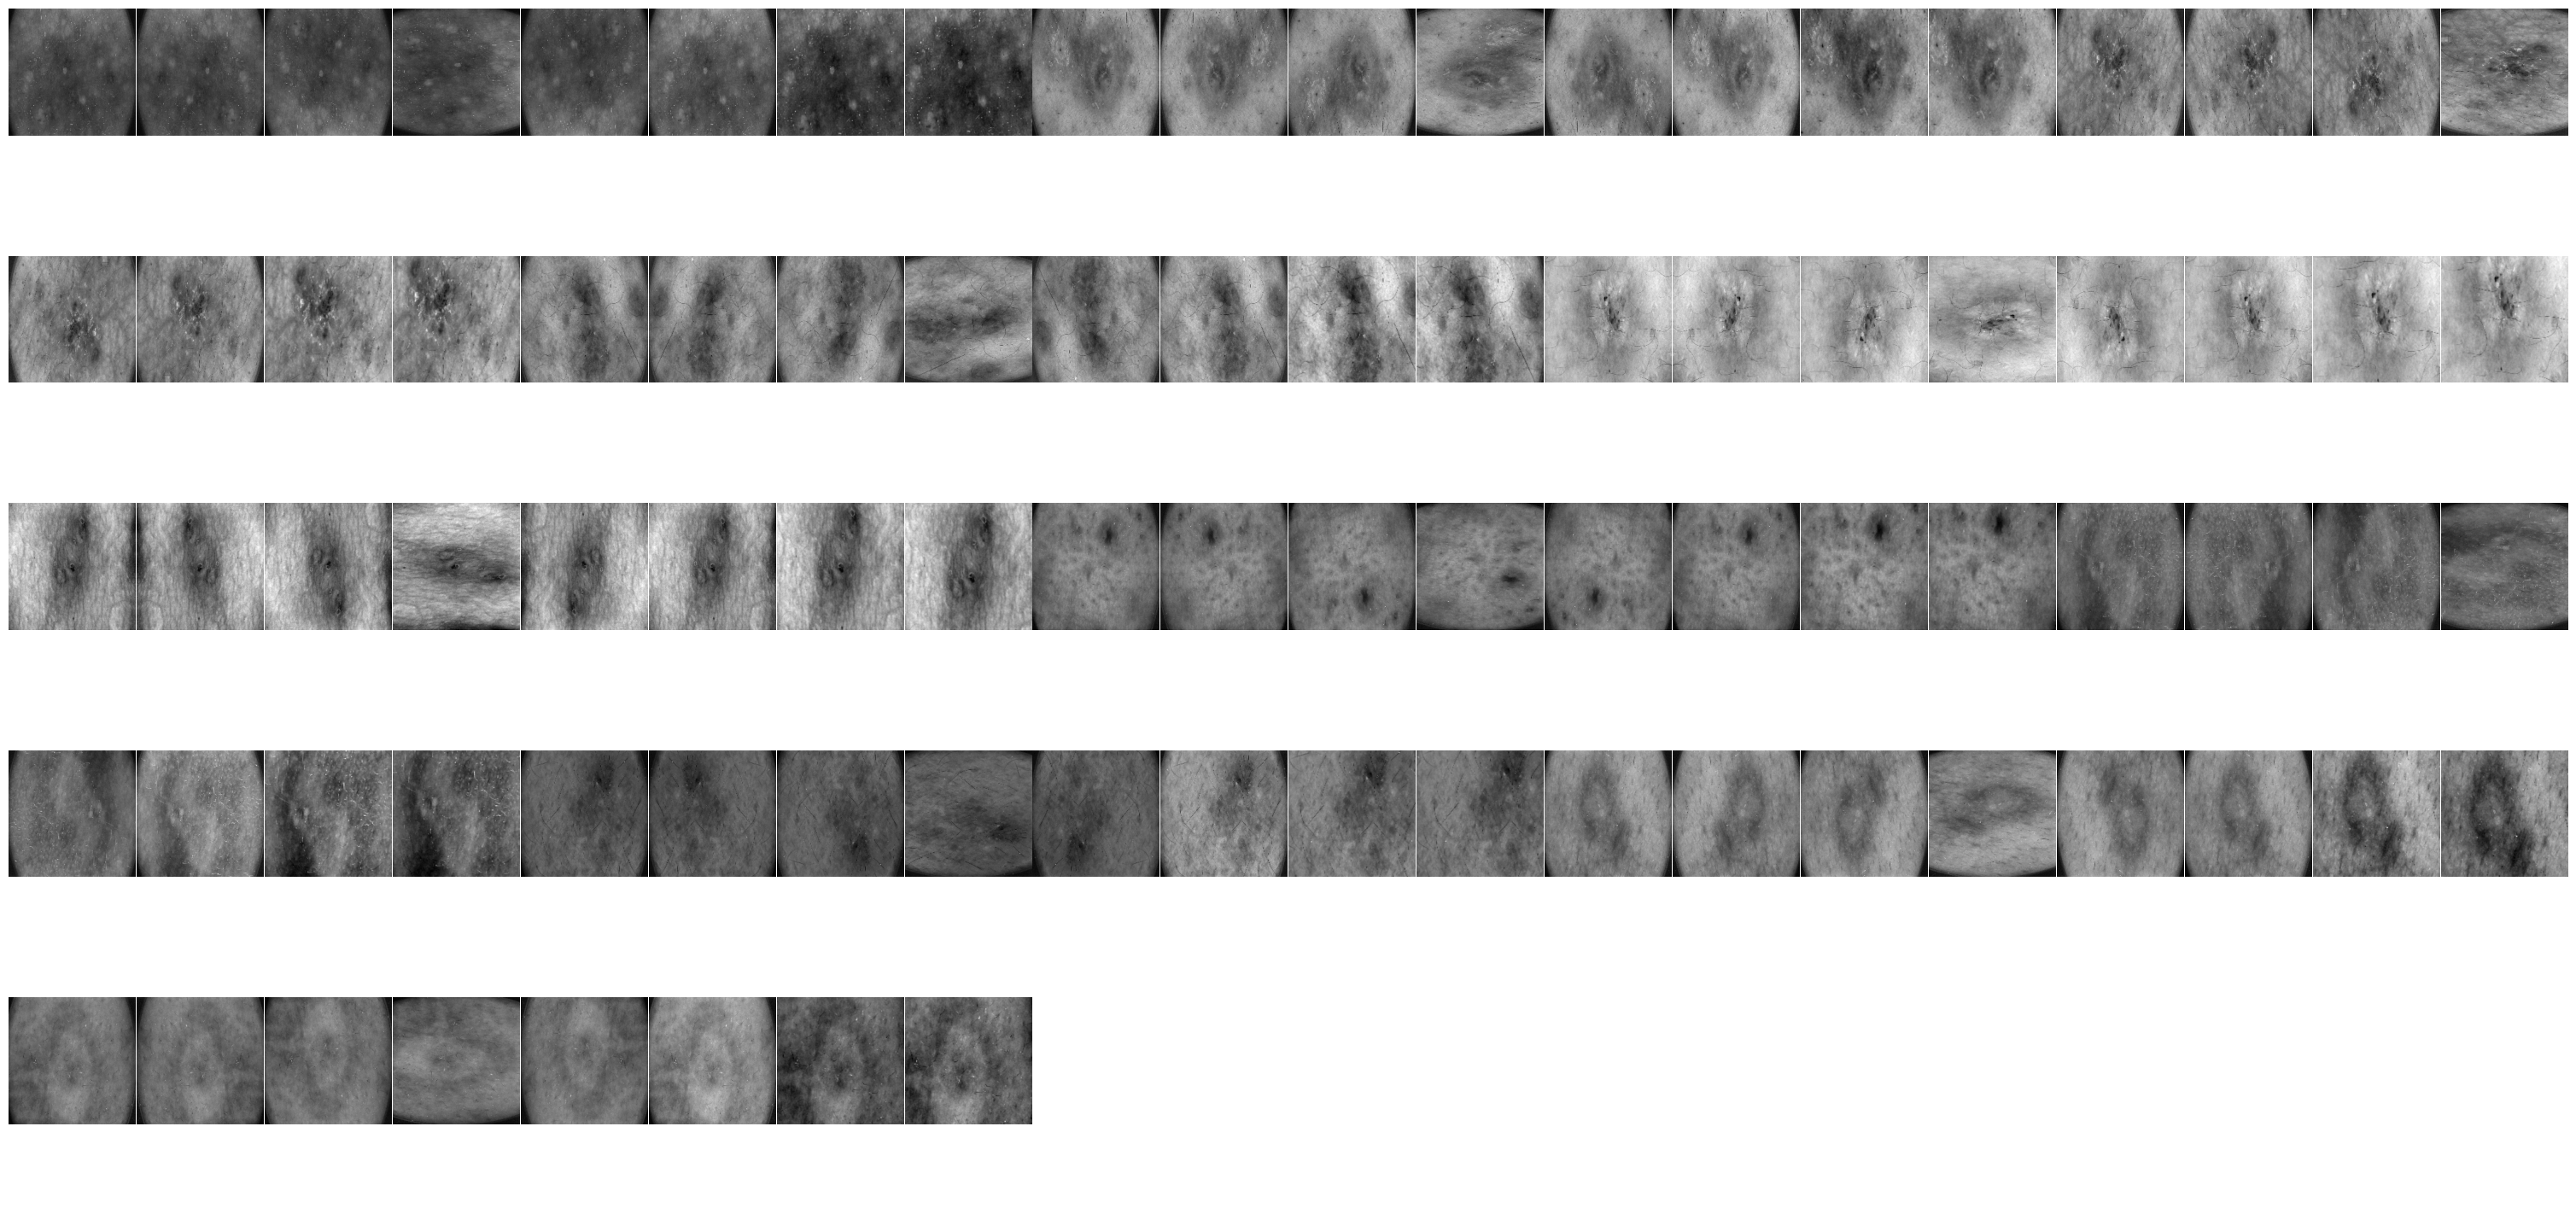

In [40]:
num_images = min(len(dataPreprocessed), 88)  

cols = 20  
rows = (num_images // cols) + (1 if num_images % cols else 0)  

fig, axes = plt.subplots(rows, cols, figsize=(30, 15))

for i, ax in enumerate(axes.flat):
    
    if i < num_images:
        img = dataPreprocessed[i]  
        ax.imshow(img, cmap='gray')
        ax.axis("off")
    else:
        ax.axis("off")  

plt.tight_layout(pad=0.1)  
plt.show()

<h1>Feature Extraction</h1>

In [41]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [42]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [43]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [44]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [45]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [46]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [47]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

In [48]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [49]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [50]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

In [51]:
for i in range(len(dataPreprocessed)):
    H0 = homogenity(Derajat0[i])
    homogenity0.append(H0)
    H45 = homogenity(Derajat45[i])
    homogenity45.append(H45)
    H90 = homogenity(Derajat90[i])
    homogenity90.append(H90)
    H135 = homogenity(Derajat135[i])
    homogenity135.append(H135)

In [52]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [53]:
for i in range(len(dataPreprocessed)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [54]:
for i in range(len(dataPreprocessed)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [55]:
for i in range(len(dataPreprocessed)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [56]:
for i in range(len(dataPreprocessed)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [57]:
for i in range(len(dataPreprocessed)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

In [58]:
print(df.describe())  # Lihat ringkasan statistik fitur

         Contrast0   Contrast45   Contrast90  Contrast135  Homogeneity0  \
count   176.000000   176.000000   176.000000   176.000000    176.000000   
mean    177.624127   180.554619   173.848430   180.575154      0.269342   
std     415.091616   414.888890   415.327662   414.896749      0.126978   
min       1.866592     2.529751     0.889574     2.538358      0.033562   
25%      15.891656    18.175833    13.014274    18.192679      0.241063   
50%      20.954476    23.864606    17.290018    23.161073      0.262989   
75%      34.739485    37.870760    26.734605    37.267716      0.290458   
max    1302.090987  1316.796577  1321.528567  1319.353536      0.581342   

       Homogeneity45  Homogeneity90  Homogeneity135  Dissimilarity0  \
count     176.000000     176.000000      176.000000      176.000000   
mean        0.250746       0.300913        0.250476        6.307547   
std         0.114213       0.156409        0.113679        8.441275   
min         0.033443       0.032693     

<h1>CSV</h1>

In [59]:
dataTable = {'Filename': filenames, 'Label': path,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_tanpa_prepro.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_tanpa_prepro.csv')
hasilEkstrak

,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,103_2.jpg,Acne Vulgaris,38.289878,41.240906,30.082779,40.173500,0.256977,0.249674,0.291444,0.253339,...,0.002322,0.002007,0.045353,0.044583,0.048182,0.044797,0.864620,0.852852,0.894580,0.856659
1,103_2.jpg,Acne Vulgaris,38.289878,40.173500,30.082779,41.240906,0.256977,0.253339,0.291444,0.249674,...,0.002322,0.001988,0.045353,0.044797,0.048182,0.044583,0.864620,0.856659,0.894580,0.852852
2,103_2.jpg,Acne Vulgaris,38.289878,40.173500,30.082779,41.240906,0.256977,0.253339,0.291444,0.249674,...,0.002322,0.001988,0.045353,0.044797,0.048182,0.044583,0.864620,0.856659,0.894580,0.852852
3,103_2.jpg,Acne Vulgaris,30.082779,40.173500,38.289878,41.240906,0.291444,0.253339,0.256977,0.249674,...,0.002057,0.001988,0.048182,0.044797,0.045353,0.044583,0.894580,0.856659,0.864620,0.852852
4,103_2.jpg,Acne Vulgaris,38.289878,41.240906,30.082779,40.173500,0.256977,0.249674,0.291444,0.253339,...,0.002322,0.002007,0.045353,0.044583,0.048182,0.044797,0.864620,0.852852,0.894580,0.856659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,10_3.jpg,Rosacea,9.453756,14.235999,13.194947,14.648394,0.327567,0.284565,0.290458,0.278075,...,0.002897,0.002764,0.057889,0.052996,0.053825,0.052571,0.942383,0.912786,0.919717,0.910258
172,10_3.jpg,Rosacea,13.194947,14.648394,9.453756,14.235999,0.290458,0.278075,0.327567,0.284565,...,0.003351,0.002809,0.053825,0.052571,0.057889,0.052996,0.919717,0.910258,0.942383,0.912786
173,10_3.jpg,Rosacea,22.394599,24.866094,16.093570,24.164049,0.248213,0.237160,0.281944,0.243082,...,0.003351,0.002809,0.053825,0.052571,0.057889,0.052996,0.919386,0.909871,0.941971,0.912417
174,10_3.jpg,Rosacea,5.421024,7.210219,3.376742,6.947877,0.414979,0.370288,0.481295,0.376667,...,0.006365,0.004530,0.071680,0.066403,0.079783,0.067308,0.952829,0.937076,0.970602,0.939358


<Axes: >

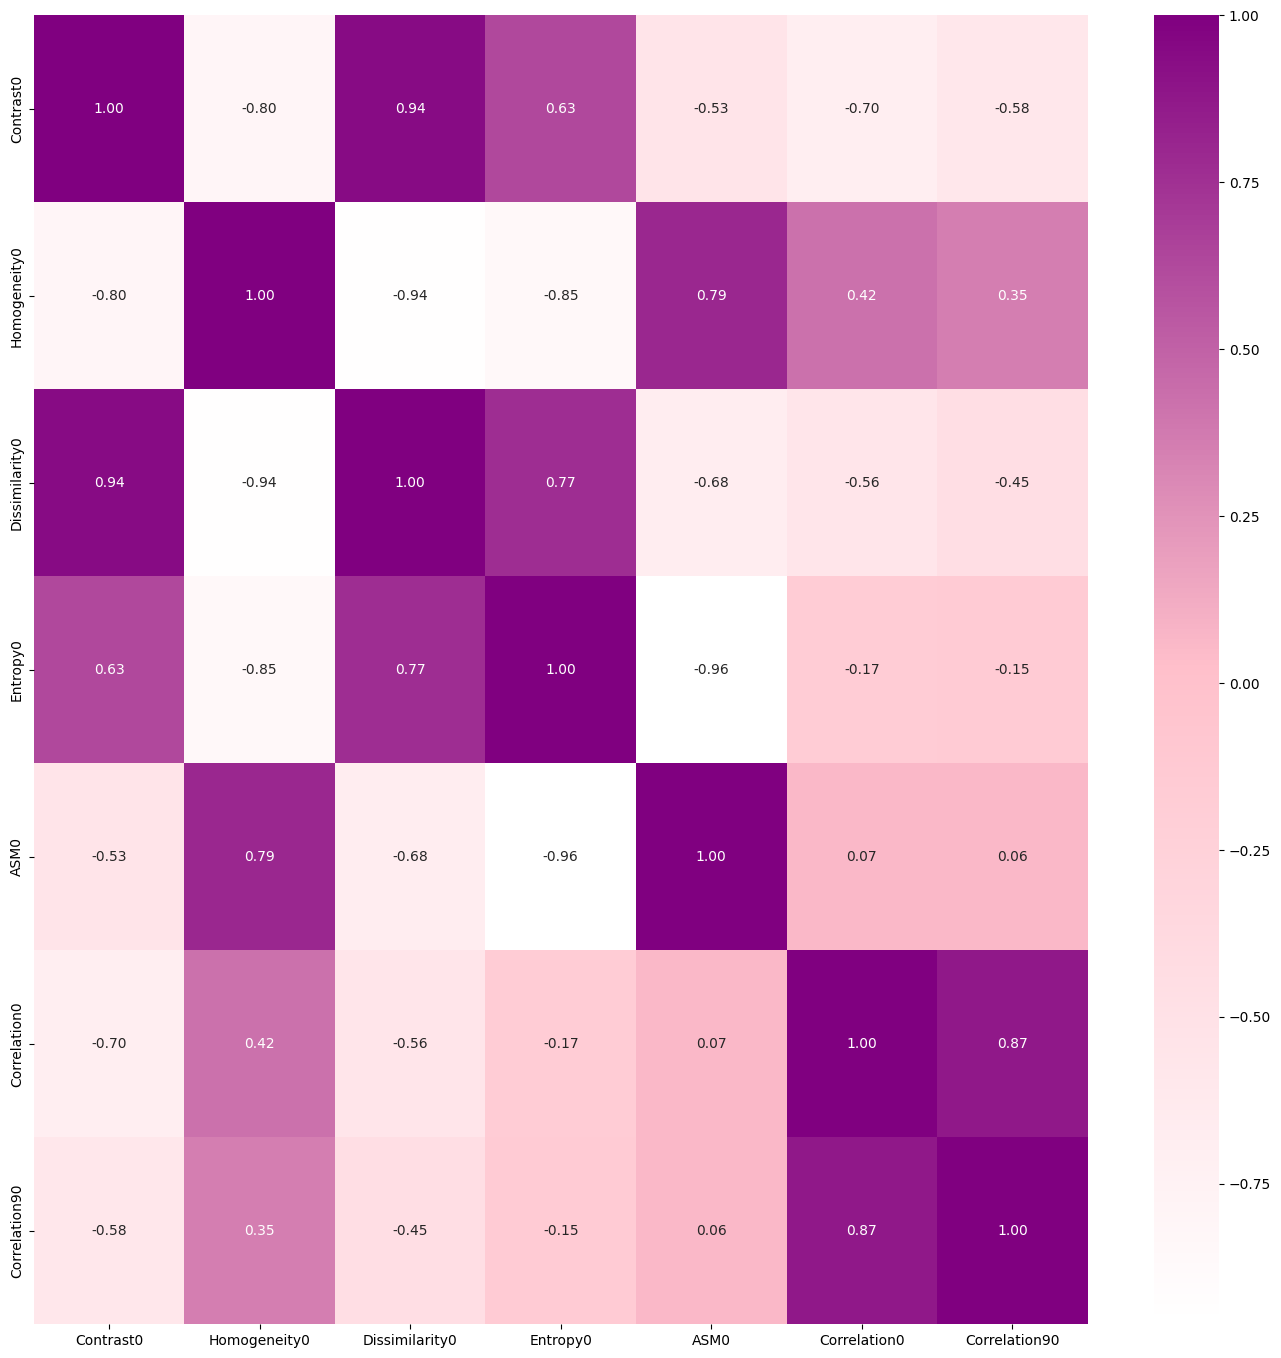

In [60]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))

pink_cmap = LinearSegmentedColormap.from_list("pink_shade", ["white", "pink", "purple"], N=256)
sns.heatmap(x_new.corr(), annot=True, cmap=pink_cmap, fmt=".2f")

In [61]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)

(123, 7)
(53, 7)


In [62]:

# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

In [63]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

In [64]:
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
               precision    recall  f1-score   support

Acne Vulgaris       1.00      0.95      0.97        61
      Rosacea       0.95      1.00      0.98        62

     accuracy                           0.98       123
    macro avg       0.98      0.98      0.98       123
 weighted avg       0.98      0.98      0.98       123

[[58  3]
 [ 0 62]]
Accuracy: 0.975609756097561

------Testing Set------
               precision    recall  f1-score   support

Acne Vulgaris       0.95      0.78      0.86        27
      Rosacea       0.81      0.96      0.88        26

     accuracy                           0.87        53
    macro avg       0.88      0.87      0.87        53
 weighted avg       0.88      0.87      0.87        53

[[21  6]
 [ 1 25]]
Accuracy: 0.8679245283018868


In [65]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
               precision    recall  f1-score   support

Acne Vulgaris       0.95      0.69      0.80        61
      Rosacea       0.76      0.97      0.85        62

     accuracy                           0.83       123
    macro avg       0.86      0.83      0.83       123
 weighted avg       0.86      0.83      0.83       123

[[42 19]
 [ 2 60]]
Accuracy: 0.8292682926829268

------Testing Set------
               precision    recall  f1-score   support

Acne Vulgaris       1.00      0.63      0.77        27
      Rosacea       0.72      1.00      0.84        26

     accuracy                           0.81        53
    macro avg       0.86      0.81      0.81        53
 weighted avg       0.86      0.81      0.81        53

[[17 10]
 [ 0 26]]
Accuracy: 0.8113207547169812


In [66]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
               precision    recall  f1-score   support

Acne Vulgaris       0.88      0.85      0.87        61
      Rosacea       0.86      0.89      0.87        62

     accuracy                           0.87       123
    macro avg       0.87      0.87      0.87       123
 weighted avg       0.87      0.87      0.87       123

[[52  9]
 [ 7 55]]
Accuracy: 0.8699186991869918

------Testing Set------
               precision    recall  f1-score   support

Acne Vulgaris       0.79      0.70      0.75        27
      Rosacea       0.72      0.81      0.76        26

     accuracy                           0.75        53
    macro avg       0.76      0.76      0.75        53
 weighted avg       0.76      0.75      0.75        53

[[19  8]
 [ 5 21]]
Accuracy: 0.7547169811320755


In [67]:
print("\n------Train Set RF------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

print("\n------Train Set SVM------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

print("\n------Train Set KNN------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)


------Train Set RF------
               precision    recall  f1-score   support

Acne Vulgaris       1.00      0.95      0.97        61
      Rosacea       0.95      1.00      0.98        62

     accuracy                           0.98       123
    macro avg       0.98      0.98      0.98       123
 weighted avg       0.98      0.98      0.98       123

[[58  3]
 [ 0 62]]
Accuracy: 0.975609756097561

------Train Set SVM------
               precision    recall  f1-score   support

Acne Vulgaris       0.95      0.69      0.80        61
      Rosacea       0.76      0.97      0.85        62

     accuracy                           0.83       123
    macro avg       0.86      0.83      0.83       123
 weighted avg       0.86      0.83      0.83       123

[[42 19]
 [ 2 60]]
Accuracy: 0.8292682926829268

------Train Set KNN------
               precision    recall  f1-score   support

Acne Vulgaris       0.88      0.85      0.87        61
      Rosacea       0.86      0.89      0.87    

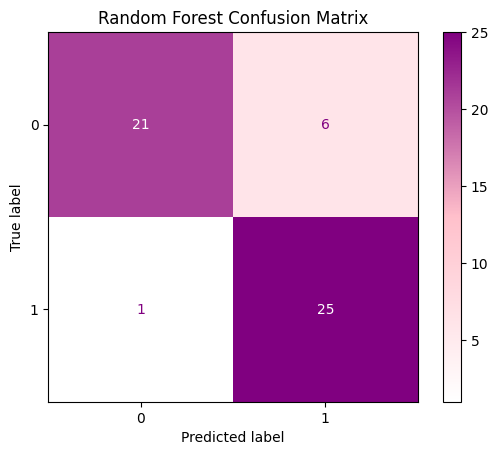

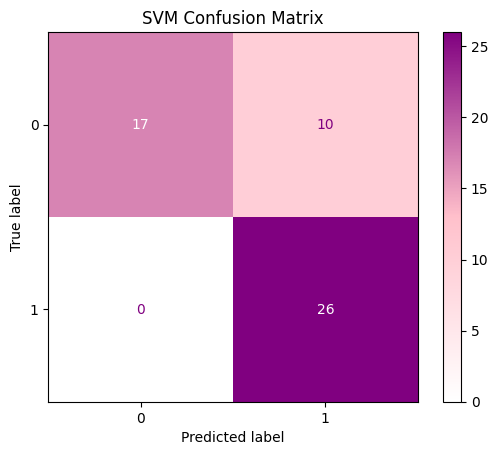

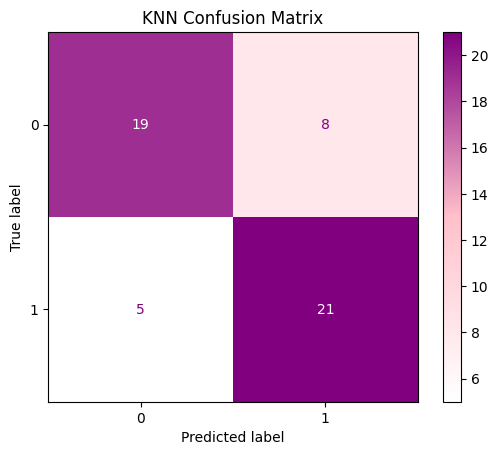

In [68]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=pink_cmap)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")